In [193]:
# -*- coding: utf-8 -*-
"""
Created on Sat november 05 13:18:15 2016
@author: Sidon
"""
%matplotlib inline
import pandas as pd
import numpy as np
from collections import OrderedDict
from tabulate import tabulate, tabulate_formats
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%f'%x)

usecols = ['country','incomeperperson','alcconsumption','armedforcesrate','breastcancerper100th','co2emissions',
           'femaleemployrate','internetuserate','lifeexpectancy','polityscore', 'relectricperperson',
           'suicideper100th', 'employrate', 'urbanrate']


# Load from CSV
data0 = pd.read_csv('~/dev/coursera/gapminder.csv', skip_blank_lines=True,
                     usecols=usecols)


In [194]:
def to_num(list, data):
    for dt in list :
        data[dt] = pd.to_numeric(data[dt], 'errors=coerce')
    return data    
        

In [195]:

def interpret_clusters(n, train):
    
    model=KMeans(n_clusters=n)
    model.fit(train)
    
    # plot clusters
    pca_2 = PCA(2)
    
    plt.subplots(figsize=(12, 8))
    plot_columns = pca_2.fit_transform(train)

    sc = plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model.labels_, s=200)
 
    plt.xlabel('Canonical variable 1')
    plt.ylabel('Canonical variable 2')
    plt.title('Scatterplot of Canonical Variables for '+str(n)+' Clusters')
    plt.show()
    return model

In [196]:
columns = ['country','income','alcohol','army','bcancer','co2','female-employ','net-rate','life', 'polity',
           'relectricperperson', 'suicideper100th', 'employ','urban']

cluster_cols = columns.copy()
for column in ['country', 'life']:
    cluster_cols.remove(column)
    
#cluster_cols = ['income','alcohol', 'net-rate' ]    

In [197]:
# Rename columns for clarity                                    
data0.columns = columns

# converting to numeric values and parsing (numeric invalids=NaN)
data0 = to_num( cluster_cols+['life'], data0 )

# Remove rows with nan values
data0 = data0.dropna(axis=0, how='any')

# Copy dataframe for preserve original
data1 = data0.copy()

In [198]:
# Subset clustering variables
cluster = data1[cluster_cols]
#print (cluster)

In [199]:
# standardize clustering variables to have mean=0 and sd=1
cluster_s=cluster.copy()

for c in cluster_s:
    cluster_s[c]=preprocessing.scale(cluster_s[c].astype('float64'))

#print(cluster_s)

In [200]:
# split data into train and test sets
clus_train, clus_test =  train_test_split(cluster_s, test_size=.3, random_state=123)


In [201]:
# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
range_clusters=range(1,9)
meandist=[]

for k in range_clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])


In [202]:
print (meandist)    

[3.1108099467242418, 2.6067405118778573, 2.3378498636470839, 2.1875343243904761, 2.001648110406014, 1.9536646453980457, 1.8581314669831883, 1.7708652244099634]


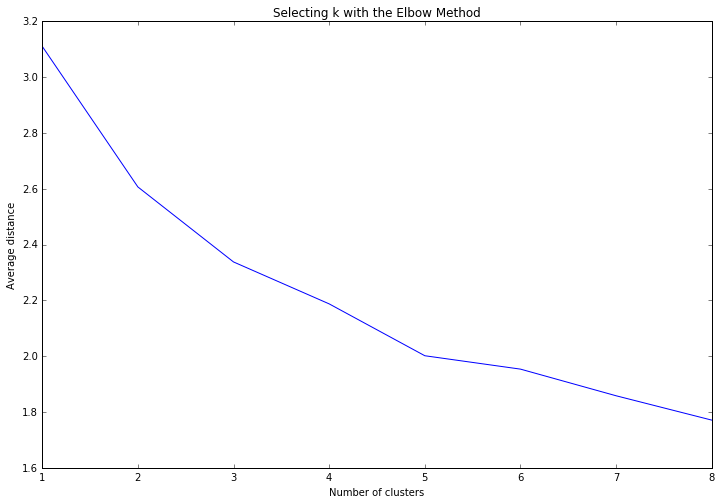

In [203]:
"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
plt.subplots(figsize=(12, 8))
plt.plot(range_clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

plt.show()


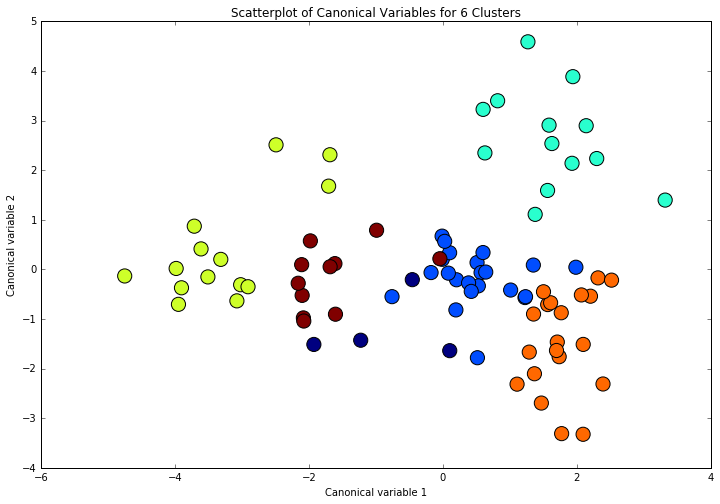

In [204]:
# Interpret 3 cluster solution
model = interpret_clusters(6, clus_train)

In [205]:
#model = models[2][0]

clus_train.reset_index(level=0, inplace=True)
cluslist=list(clus_train['index'])
labels=list(model.labels_)

newlist=dict(zip(cluslist, labels))
newclus=pd.DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']

In [206]:
newclus.reset_index(level=0, inplace=True)
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
merged_train.cluster.value_counts()

1    22
4    20
3    14
2    13
5    11
0     4
Name: cluster, dtype: int64

In [207]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
             index    income   alcohol      army   bcancer       co2  \
cluster                                                                
0        95.250000 -0.449754  1.575244  0.318238 -0.099987 -0.042761   
1        96.409091 -0.477989 -0.075115 -0.365878 -0.409090 -0.192537   
2       122.000000 -0.422274 -1.243002  1.358967 -0.561217 -0.165132   
3       106.714286  2.054106  0.380889  0.006889  1.412843  0.253898   
4       118.100000 -0.700819 -0.625534 -0.483895 -0.820442 -0.041124   
5       101.909091 -0.001287  1.062515 -0.330803  0.686120 -0.138079   

         female-employ  net-rate    polity  relectricperperson  \
cluster                                                          
0             0.465595  0.175307 -0.643776           -0.271658   
1            -0.000642 -0.408808  0.324670           -0.415649   
2            -1.671753 -0.402674 -1.243898           -0.166937   
3             0.275823  1.504251  0.504679            1.

In [208]:
# validate clusters in training data by examining cluster differences in GPA using ANOVA
# first have to merge GPA with clustering variables and cluster assignment data 
gpa_data=data0['life']
# split GPA data into train and test sets
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1=pd.DataFrame(gpa_train)
gpa_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(gpa_train1, merged_train, on='index')
sub1 = merged_train_all[['life', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

gpamod = smf.ols(formula='life ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:                   life   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     18.01
Date:                Sat, 12 Nov 2016   Prob (F-statistic):           7.77e-12
Time:                        16:12:59   Log-Likelihood:                -271.09
No. Observations:                  84   AIC:                             554.2
Df Residuals:                      78   BIC:                             568.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          69.6050      3.165     

In [209]:
print ('means for life by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)


means for life by cluster
             life
cluster          
0       69.605000
1       70.505545
2       71.455538
3       80.871286
4       60.785150
5       74.770091


In [210]:
print ('standard deviations for life by cluster')
m2= sub1.groupby('cluster').std()
print (m2)


standard deviations for life by cluster
            life
cluster         
0       2.218008
1       7.058163
2       4.345871
3       1.184780
4       8.054975
5       7.662149


In [211]:
mc1 = multi.MultiComparison(sub1['life'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  0      1     0.9005  -9.1526  10.9537  False 
  0      2     1.8505  -8.7244  12.4255  False 
  0      3    11.2663   0.7806   21.752   True 
  0      4    -8.8199   -18.95   1.3103  False 
  0      5     5.1651  -5.6337  15.9639  False 
  1      2      0.95    -5.52     7.42   False 
  1      3    10.3657   4.0426  16.6889   True 
  1      4    -9.7204  -15.4346 -4.0062   True 
  1      5     4.2645  -2.5652  11.0943  False 
  2      3     9.4157   2.2921  16.5394   True 
  2      4    -10.6704 -17.2595 -4.0813   True 
  2      5     3.3146  -4.2624  10.8915  False 
  3      4    -20.0861 -26.531  -13.6412  True 
  3      5    -6.1012  -13.5531  1.3507  False 
  4      5    13.9849   7.0423  20.9276   True 
-----------------------------------------------
